BorrowmanFlow.pyより必要なクラス・関数を宣言. ここは変更しなくてOK.

メイン部分を実行前に一度ここを実行してください.

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def mm2m(value):
    return value / 1000.0

class Nose:
    def __init__(self, stage, shape, l_nose):
        self.Cmq = 0.0
        self.Clp = 0.0
        self.Cnr = 0.0

        self.LD = l_nose / stage.d_body # copy for graph plot
        doublecone_pattern = r'double|double ?cone|cone'
        ogive_pattern = r'ogive|ogive ?cone'
        parabolic_pattern = r'parabolic|ellipse'
        if re.compile(doublecone_pattern, re.IGNORECASE).match(shape):
            CP_coefficient = 2.0 / 3.0
        elif re.compile(ogive_pattern, re.IGNORECASE).match(shape):
            CP_coefficient = 1.0 - ((8.0 * self.LD ** 2 / 3.0) + ((4.0 * self.LD ** 2 - 1.0) ** 2 / 4.0) - (((4.0 * self.LD ** 2 - 1.0) * (4.0 * self.LD ** 2 + 1.0) ** 2 / (16.0 * self.LD)) * np.arcsin(4.0 * self.LD / (4.0 * self.LD ** 2 + 1.0))))
        elif re.compile(parabolic_pattern, re.IGNORECASE).match(shape):
            CP_coefficient =  0.5

        self.CNa = 2.0
        self.Lcp = l_nose * CP_coefficient


class TaperBody:
    def __init__(self, stage, d_before, d_after, l_taper, distance_fromNoseTip):
        self.Cmq = 0.0
        self.Clp = 0.0
        self.Cnr = 0.0

        self.d_before = d_before # copy for graph plot
        self.d_after = d_after
        self.l_taper = l_taper
        self.distance = distance_fromNoseTip

        self.CNa = 2.0 * ((d_after / d_before) ** 2 - 1.0)
        self.Lcp = distance_fromNoseTip + (l_taper / 3.0) * (1.0 + ((1.0 - (d_before / d_after)) / (1.0 - (d_before / d_after) ** 2)))


class Fin:
    def __init__(self, stage, Cr, Ct, Cle, span, distance_fromNoseTip_toRootchordLeadingEdge):
        self.Cmq = 0.0
        self.Clp = 0.0
        self.Cnr = 0.0

        # input unit [m]
        # Cr:Root Chord
        # Ct:Tip Chord
        # Cle:Leading Edge Chord
        self.Cr = Cr # copy for graph plot
        self.Ct = Ct
        self.Cle = Cle
        self.span = span
        self.distance = distance_fromNoseTip_toRootchordLeadingEdge

        # フィン形状による分岐
        if Cle+0.5*Ct == 0.5*Cr:
            mid_chord_line = span
        elif Cle+0.5*Ct > 0.5*Cr:
            mid_chord_line = np.sqrt(span ** 2 + (0.5 * Ct + Cle - 0.5 * Cr) ** 2)
        else:
            mid_chord_line = np.sqrt(span ** 2 + (0.5 * Cr - Cle - 0.5 * Ct) ** 2)

        CNa_single = 16.0 * (span / stage.d_body) ** 2 / (1.0 + np.sqrt(1.0 + (2.0 * mid_chord_line / (Cr + Ct)) ** 2)) # 4fins
        Kfb = 1.0 + 0.5 * stage.d_body / (0.5 * stage.d_body + span) # interference fin and body
        self.CNa = CNa_single * Kfb

        ramda = Ct / Cr
        MAC = 2.0 / 3.0 * Cr * (1 + ramda ** 2 / (1.0 + ramda)) # Mean Aerodynamic Chord
        self.Lcp = self.distance + (Cle * (Cr + 2.0 * Ct) / (3.0 * (Cr + Ct))) + MAC / 4.0
        self.Clp = -4.0 * 2.0 * (span + 0.5 * stage.d_body) ** 4 / (np.pi * stage.l_body ** 2 * (0.25 * stage.d_body ** 2 * np.pi))

    def flutter_speed(self, young, poisson, thickness, altitude=0.0):
        # ref. NACA Technical Note 4197
        # young:Young`s modulus [GPa]
        # possion:Poisson Ratio
        # thickness:Fin thickness [m]

        def Std_Atmo(altitude):
            # ref. 1976 standard atmosphere
            # ジオポテンシャル高度を基準として標準大気の各層の気温減率から各大気値を算出
            # 高度86 kmまで対応
            # altitude [m]
            R = 287.1
            gamma = 1.4
            Re = 6378.137e3 # Earth Radius [m]
            g0 = 9.80665

            # atmospheric layer
            h_list  = [0.0, 11.0e3, 20.0e3, 32.0e3, 47.0e3, 51.0e3, 71.0e3, 84.852e3] # geopotential height [m]
            TG_list = [-6.5e-3, 0.0, 1.0e-3, 2.8e-3, 0, -2.8e-3, -2.0e-3, 0.0] # Temp. gradient [K/m]
            T_list  = [288.15, 216.65, 216.65, 228.65, 270.65, 270.65, 214.65, 186.946] # [K]
            P_list  = [101325.0, 22632.0, 5474.9, 868.02, 110.91, 66.939, 3.9564, 0.3734] # [Pa]

            h = altitude * Re / (Re + altitude) # geometric altitude => geopotential height

            k = 0 # dafault layer
            for i in range(8):
                if h < h_list[i]:
                    k = i - 1
                    break
                elif h >= h_list[7]:
                    k = 7
                    break

            temperature = T_list[k] + TG_list[k] * (h - h_list[k]) # [K]
            if TG_list[k] == 0.0:
                pressure = P_list[k] * np.exp(g0 / R * (h_list[k] - h) / T_list[k])
            else:
                pressure = P_list[k] * np.power(T_list[k] / temperature, g0 / R / TG_list[k]) # [Pa]
            density = pressure / (R * temperature) # [kg/m^3]
            soundspeed = np.sqrt(gamma * R * temperature) # [m/s]

            return temperature, pressure, density, soundspeed

        AR = 2.0 * self.span / (self.Cr + self.Ct) # aspect ratio
        ramda = self.Ct / self.Cr # taper ratio
        shear = young / (2.0 * (1.0 + poisson)) # shear modulus
        self.Vf = Std_Atmo(altitude)[3] * np.sqrt(shear * 10.0 ** 9 / ((1.337 * AR ** 3 * Std_Atmo(altitude)[1] * (ramda + 1.0)) / (2.0 * (AR + 2.0) * (thickness / self.Cr) ** 3)))
        return self.Vf

    def center_of_gravity_for_fin(self, mass_body, cg_body, thickness, rho_fin):
        AR = (self.Cr + self.Ct) * self.span * 0.5
        self.mass_fin = AR * thickness * rho_fin * 4
        cg_fin = self.distance + (self.Cr - (self.Ct ** 2 + self.Cr * self.Ct + self.Cr ** 2) / (3.0 * (self.Cr + self.Ct)))
        cg_move = (cg_body * mass_body + cg_fin * self.mass_fin) / (mass_body + self.mass_fin)
        return cg_move  # [m]


class Stage:
    def __init__(self, d_body, l_body, Lcg):
        self.d_body = d_body
        self.l_body = l_body
        self.Lcg = Lcg

    def integrate(self, components):
        self.Lcp = 0.0
        self.CNa = 0.0
        self.Cmq = 0.0
        self.Cnr = 0.0
        self.Clp = 0.0
        self.graph_components = []

        for obj in components:
            self.CNa += obj.CNa
            self.Lcp += obj.CNa * obj.Lcp
            self.Cmq -= 4.0 * (0.5 * obj.CNa * ((obj.Lcp - self.Lcg) / self.l_body) ** 2)
            self.Clp += obj.Clp
        self.graph_components = components
        self.Lcp /= self.CNa

    def plot(self):
        graph = Graph(self)
        graph.plot()



class Graph:
    # グラフによる機体形状の可視化
    # 単純な単段ロケットのみ対応
    # @ToDo:汎用性を上げる
    def add_point(self, array, x, y):
        return np.vstack((array, np.array([x, y])))

    def add_body_reverse(self, point_list):
        point_parse = point_list[:-1,:]
        for point in point_parse[::-1]:
            point_list = self.add_point(point_list, point[0], point[1] * (-1))
        return point_list

    def add_fin_reverse(self, point_list):
        point_list = self.add_point(point_list, point_list[0,0], point_list[0,1]) # 1st fin close
        point_2nd = np.array([point_list[0,0], -point_list[0,1]])
        for point in point_list[1:]:
            point_2nd = self.add_point(point_2nd, point[0], point[1] * (-1)) # 2nd fin point
        return point_list, point_2nd

    def __init__(self, stage):
        self.Lcg = stage.Lcg
        self.Lcp = stage.Lcp
        self.point_set = []
        for component in stage.graph_components:
            if isinstance(component, Nose):
                if hasattr(self, 'point_nose'):
                    pass
                else:
                    self.point_nose = np.array([0.0, 0.0])
                self.point_nose = self.add_point(self.point_nose, component.LD*stage.d_body, 0.5*stage.d_body)
                self.point_nose = self.add_point(self.point_nose, component.LD*stage.d_body, 0.0)
                self.point_nose = self.add_body_reverse(self.point_nose)
                self.point_set.append(self.point_nose)

            elif isinstance(component, TaperBody):
                if hasattr(self, 'point_taper'):
                    pass
                else:
                    self.point_taper = np.array([component.distance, 0.0])
                self.point_taper = self.add_point(self.point_taper, component.distance, 0.5*component.d_before)
                self.point_taper = self.add_point(self.point_taper, component.distance+component.l_taper, 0.5*component.d_after)
                self.point_taper = self.add_point(self.point_taper, component.distance+component.l_taper, 0.0)
                self.point_taper = self.add_body_reverse(self.point_taper)
                self.point_set.append(self.point_taper)

            elif isinstance(component, Fin):
                if hasattr(self, 'point_fin'):
                    pass
                else:
                    self.point_fin = np.array([component.distance, 0.5*stage.d_body])
                self.point_fin = self.add_point(self.point_fin, component.distance+component.Cle, 0.5*stage.d_body+component.span)
                self.point_fin = self.add_point(self.point_fin, component.distance+component.Cle+component.Ct, 0.5*stage.d_body+component.span)
                self.point_fin = self.add_point(self.point_fin, component.distance+component.Cr, 0.5*stage.d_body)
                self.point_fin, self.point_fin_2nd = self.add_fin_reverse(self.point_fin)
                self.point_set.append(self.point_fin)
                self.point_set.append(self.point_fin_2nd)

        # add body
        start_x = max(self.point_nose[:,0])
        end_x = stage.l_body
        self.point_body = np.array([start_x, -0.5*stage.d_body])
        self.point_body = self.add_point(self.point_body, start_x, 0.5*stage.d_body)
        self.point_body = self.add_point(self.point_body, end_x, 0.5*stage.d_body)
        self.point_body = self.add_point(self.point_body, end_x, -0.5*stage.d_body)
        self.point_body = self.add_point(self.point_body, start_x, -0.5*stage.d_body)
        self.point_set.append(self.point_body)

    def plot(self):
        plt.close('all')
        plt.figure(0, figsize=(8, 4))
        xmax = 0.0
        ymax = 0.0
        for point_list in self.point_set:
            try:
                plt.plot(point_list[:,0], point_list[:,1], color='black')
                if max(point_list[:,0]) > xmax:
                    xmax = max(point_list[:,0])
                if max(point_list[:,1]) > ymax:
                    ymax = max(point_list[:,1])
            except:
                pass
        plt.plot(self.Lcg, 0.0, 'o', color='black', label='Lcg')
        plt.plot(self.Lcp, 0.0, 'o', color='red', label='Lcp')
        plt.xlim([0.0, np.ceil(xmax)])
        plt.ylim([np.floor(-ymax), np.ceil(ymax)])
        ax = plt.gca()
        aspect = 1.0
        ax.set_aspect(aspect)
        plt.grid()
        plt.legend()
        plt.show()


# Optimize
class FinOptimize:
    def __init__(self):
        pass

    def set_param_init(self, param):
        self.param_init = param

    def solve(self, config):
        cons = ({'type':'eq', 'fun': lambda param:self.equality(param, config)}, {'type':'ineq', 'fun': lambda param:self.inequality(param, config)})
        result = minimize(self.cost, self.param_init, args=(config,), constraints=cons, method='SLSQP', options={'maxiter': 300})#, 'disp': True, })
        return result


class Conditions:
    def __init__(self):
        self.value_list = []

    def __call__(self):
        return self.value_list

    def equal(self, target, value):
        self.value_list.append(target - value)

    def upper_bound(self, target, max_value):
        self.value_list.append(max_value - target)

    def lower_bound(self, target, min_value):
        self.value_list.append(target - min_value)



メイン部分

*=============Result==============*
Length of C.P.: 0.903515612852901 [m]
Length of C.G.: 0.7591016311648436 [m]
Safety Ratio of Length: 9.652050640827257 [%]
Coefficient of Normal Force: 6.595194567917445 [deg^-1]
Coefficient of Pitch Damping Moment: -1.959275365386438 [-]
Coefficient of Roll Damping Moment: -0.061415598002210504 [-]
Flutter Velocity: 48.95190370198523 [m/s]
Mass of Fin: 0.24000000000000005 [kg]
Mass of Body + Fin: 6.948 [kg]
*=================================*


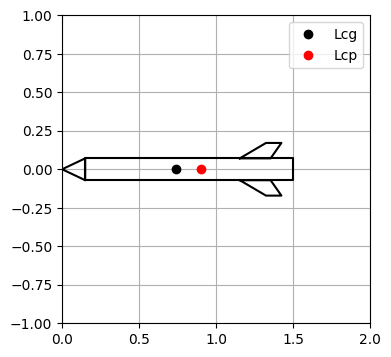

In [ ]:
################## ここに緒元を代入 ##################
length_body = 1.4962 # [m] from nose tip to body. without tail
diameter_body = 0.142 # [m]
mass_body = 6.708  # [kg]
length_cg = 0.7406 # [m] from nose tip

shape_nose = 'ogive' # 'ogive' or 'double' or 'parabolic' or 'ellipse'
length_nose = 0.15 # [m]

diameter_tail = 0.0616 # [m]
length_tail = 0.128 # [m]

offset_fin = 142.2 # [mm] from body end to fin end
root_chord = 200.0 # [mm]
tip_chord = 100 # [mm]
leading_edge_chord = 170 #root_chord - tip_chord
span = 100 # [mm]
thickness_fin = 2.0 # [mm]
young_modulus = 0.59 # [GPa]
poisson_ratio = 0.3 # [-]
# rho_fin = 1380  # [kg/m3]
rho_fin = 2000.0  # [kg/m3]
altitude = 300.0 # [m]
#####################################################

offset_fin = mm2m(offset_fin)
root_chord = mm2m(root_chord)
tip_chord = mm2m(tip_chord)
leading_edge_chord = mm2m(leading_edge_chord)
span = mm2m(span)
thickness_fin = mm2m(thickness_fin)

stage = Stage(diameter_body, length_body, length_cg)
nose = Nose(stage, shape_nose, length_nose)
fin = Fin(stage, root_chord, tip_chord, leading_edge_chord, span, length_body - offset_fin - root_chord)
fin.flutter_speed(young_modulus, poisson_ratio, thickness_fin, altitude)
length_cg = fin.center_of_gravity_for_fin(mass_body, length_cg, thickness_fin, rho_fin)
# tail = bmf.TaperBody(diameter_body, diameter_tail, length_tail, length_body)
stage.integrate([nose, fin])

print('*=============Result==============*')
print('Length of C.P.:', stage.Lcp, '[m]')
print('Length of C.G.:', length_cg, '[m]')
print('Safety Ratio of Length:', (stage.Lcp - length_cg) / length_body * 100.0, '[%]')
print('Coefficient of Normal Force:', stage.CNa, '[deg^-1]')
print('Coefficient of Pitch Damping Moment:', stage.Cmq, '[-]')
print('Coefficient of Roll Damping Moment:', stage.Clp, '[-]')
print('Flutter Velocity:', fin.Vf, '[m/s]')
print('Mass of Fin:', fin.mass_fin, '[kg]')
print('Mass of Body + Fin:', mass_body + fin.mass_fin, '[kg]')
print('*=================================*')

stage.plot()

Copyright (c) 2017 Susumu Tanaka

This software is a modified version of the original software licensed under the MIT License. Original copyright (c) 2017 Susumu Tanaka. All rights reserved.

https://github.com/sus304/BarrowmanFlow/blob/master/LICENSE


作成・改変：佐藤空馬（14期）